### Model inspired by:

- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen

### Implementation aspects:

- This implementation is more like pseudo steady-state finite difference method rather than fully dynamic FEM

In [1]:
import numpy as np
import inspect
import matplotlib.pyplot as plt
import scipy
from datetime import datetime
from scipy.optimize import root
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys

In [3]:
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src")

In [4]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

### Modelling data:

In [5]:
mp = 96       #  (submerged pipe weight) [kg/m]
N = 70        # number of modelling nodes

In [6]:
mi = [mp for i in range(N)]

In [7]:
# Vessel:

# L - the hull length
# Xg - x-center of gravity

L = 84.6 # [m]
B = 12
H = 13
Xg = L/2 # [m]
mn = 27_162_500 #123_000_000   # mass of the vessel, [kg]

In [8]:
lx, ly, lz = L/2, B/2, H/2

In [9]:
vessel_mass = mn/L # mass over length of the vessel

In [10]:
diag_Jrho0 = 1e2*np.array([1, 1, 2]) # [m^4] 
Jrho0 = np.diag(diag_Jrho0)

In [11]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [12]:
Ar=np.pi*((d0/2)**2-(dI/2)**2)   

In [13]:
E = 210e9

In [14]:
h = 100 # water depth

In [15]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [16]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [17]:
# Underwater current: 
dv1_curr = np.zeros(N)
dv2_curr = np.zeros(N)
dv3_curr = np.zeros(N)

In [18]:
# Constants: 

In [19]:
diag_DT = 1.5*np.array([1, 1, 1])
DT=np.diag(diag_DT)

In [20]:
diag_CT = 1e9*np.array([1, 1, 1 ])  
CT=np.diag(diag_CT)

In [21]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [22]:
diag_DR = 1.5*np.array([1, 1, 1])
DR=np.diag(diag_DR)

In [23]:
# for testing:

In [24]:
φ = np.random.rand(N)
θ = np.random.rand(N)
ψ = np.random.rand(N)

In [25]:
φ

array([0.20544026, 0.99668565, 0.7351349 , 0.60055765, 0.3791932 ,
       0.62643942, 0.00642535, 0.99934682, 0.66061192, 0.20228168,
       0.15510162, 0.43942017, 0.32965454, 0.24738413, 0.85504508,
       0.89215351, 0.15689707, 0.00635676, 0.96901331, 0.79911859,
       0.89968557, 0.68922074, 0.61017551, 0.32878494, 0.42078894,
       0.0103665 , 0.24643707, 0.92104378, 0.16741612, 0.99561564,
       0.90099395, 0.19518318, 0.36935323, 0.82457828, 0.92080782,
       0.34997874, 0.99791201, 0.60729105, 0.42380067, 0.83721988,
       0.84233825, 0.84791046, 0.9932315 , 0.10737896, 0.81336022,
       0.24442222, 0.28728562, 0.31556998, 0.5284854 , 0.87318507,
       0.12996239, 0.07328591, 0.9807759 , 0.17918706, 0.29722755,
       0.13583954, 0.67468851, 0.10304526, 0.70569179, 0.63329512,
       0.10181198, 0.85795306, 0.20836705, 0.23450172, 0.87043422,
       0.58766347, 0.99798732, 0.01612875, 0.56015501, 0.83772945])

In [26]:
dφ = np.random.rand(N)
dθ = np.random.rand(N)
dψ = np.random.rand(N)

In [27]:
ddφ = np.random.rand(N)
ddθ = np.random.rand(N)
ddψ = np.random.rand(N)

In [28]:
x = np.random.rand(N)
y = np.random.rand(N)
z = np.random.rand(N)

In [29]:
dx = np.random.rand(N)
dy = np.random.rand(N)
dz = np.random.rand(N)

### Main functions:

In [30]:
def Π0(φθψ):
    φ0,θ0,ψ0=φθψ
    return np.array([[np.cos(θ0),0,np.cos(φ0)*np.sin(θ0)],
                  [0,1,-np.sin(φ0)],
                  [-np.sin(θ0),0,np.cos(φ0)*np.cos(θ0)]])

In [31]:
def Π(φ,θ,ψ):
    φθψ=np.stack((φ,θ,ψ), axis=1)
    return np.apply_along_axis(Π0, 1, φθψ)

In [32]:
Π(φ,θ,ψ)

array([[[ 0.82519518,  0.        ,  0.55296966],
        [ 0.        ,  1.        , -0.20399818],
        [-0.56484769,  0.        ,  0.80784237]],

       [[ 0.98555207,  0.        ,  0.09198434],
        [ 0.        ,  1.        , -0.83967562],
        [-0.16937273,  0.        ,  0.53524176]],

       [[ 0.86491698,  0.        ,  0.37229054],
        [ 0.        ,  1.        , -0.67068722],
        [-0.50191495,  0.        ,  0.64154377]],

       [[ 0.84749394,  0.        ,  0.43792512],
        [ 0.        ,  1.        , -0.56510264],
        [-0.53080506,  0.        ,  0.69919997]],

       [[ 0.60159529,  0.        ,  0.74205709],
        [ 0.        ,  1.        , -0.37017111],
        [-0.79880105,  0.        ,  0.55886012]],

       [[ 0.79233647,  0.        ,  0.49424159],
        [ 0.        ,  1.        , -0.58626398],
        [-0.61008436,  0.        ,  0.64188768]],

       [[ 0.92025525,  0.        ,  0.39131057],
        [ 0.        ,  1.        , -0.00642531],
        

In [33]:
def w_e(φ,θ,ψ,dφ,dθ,dψ): 
    return np.einsum('ijk,ik->ij', Π(φ,θ,ψ), np.stack((dφ,dθ,dψ), axis=1))

In [34]:
w_e(φ,θ,ψ,dφ,dθ,dψ)

array([[ 0.51937041,  0.22799546,  0.15153496],
       [ 0.69957048, -0.05876635,  0.07819652],
       [ 0.84724026,  0.66641858, -0.11520323],
       [ 0.4094318 ,  0.40289881,  0.63584722],
       [ 1.02438135,  0.00143244, -0.33732216],
       [ 0.69134739,  0.52866692, -0.42613725],
       [ 0.26422523,  0.35961393, -0.01298318],
       [ 0.41691889, -0.6330108 ,  0.22951887],
       [ 0.29059812,  0.51884143,  0.29721846],
       [ 0.46493715,  0.40418149,  0.34853832],
       [ 0.53410284,  0.24323767, -0.0237932 ],
       [ 0.9235775 , -0.24571823,  0.10638608],
       [ 0.98777508,  0.27552202,  0.65144612],
       [ 0.88429501,  0.07267709,  0.31918978],
       [ 0.02339203,  0.57423278, -0.02041234],
       [ 0.49354586,  0.22798109,  0.11560565],
       [ 0.91664832,  0.13188884, -0.23263896],
       [ 1.14028905,  0.85777595,  0.08948656],
       [ 0.90672267, -0.09479352, -0.05306872],
       [ 0.78537643, -0.00258795,  0.25551084],
       [ 1.05623082,  0.22617817,  0.132

In [35]:
def dw_e(φ,θ,ψ,dφ,dθ,dψ,ddφ,ddθ,ddψ):
    return (np.einsum('ijk,ik->ij', Π(φ,θ,ψ), np.stack((ddφ,ddθ,ddψ), axis=1))+
        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1)))

In [36]:
dw_e(φ,θ,ψ,dφ,dθ,dψ,ddφ,ddθ,ddψ)

array([[ 1.37386243,  0.27271519,  0.38599751],
       [ 1.70712659,  0.05260464,  0.27227178],
       [ 1.41566905,  0.62531202, -0.35873302],
       [ 1.70467377,  0.69792174,  0.3353694 ],
       [ 1.55168602,  0.47596072, -0.14679246],
       [ 1.34217498,  0.33557173, -0.34651517],
       [ 0.82598125,  0.50588171,  0.17225632],
       [ 0.29215546, -0.05816646,  0.80422664],
       [ 0.75007524,  1.47163401,  0.27875593],
       [ 1.42049455,  1.00663168,  0.53989205],
       [ 0.5527055 ,  0.45745298,  0.03879096],
       [ 1.43373454, -0.13453047,  0.02816274],
       [ 1.96781485, -0.16831836,  0.49519315],
       [ 1.32534049, -0.01176167,  0.12019033],
       [ 0.49560688,  0.46239459, -0.34125584],
       [ 1.48902526,  1.03358434, -0.14324479],
       [ 1.86042737, -0.0430022 , -0.06349104],
       [ 2.0944604 ,  0.52915617,  0.04494572],
       [ 0.95146536, -0.06715972,  0.07121555],
       [ 1.29011453,  0.24965062,  0.84442431],
       [ 1.40927349,  0.20268301, -0.372

In [37]:
def phi(x,y,z): return np.stack((x,y,z), axis=1) 
def theta(φ,θ,ψ): return np.stack((φ,θ,ψ), axis=1) 

In [38]:
phi(x,y,z)

array([[2.84369171e-01, 5.67076942e-04, 5.84470737e-01],
       [5.46242944e-01, 1.97890305e-01, 1.07052214e-01],
       [5.52675611e-01, 9.52745601e-01, 6.98438412e-02],
       [4.79325262e-01, 4.06128658e-01, 8.11034938e-01],
       [9.82283994e-01, 6.50535262e-01, 7.20457019e-01],
       [7.33285330e-01, 1.49325739e-01, 9.19426817e-01],
       [9.80468618e-01, 3.17765661e-01, 8.91692762e-01],
       [4.58457445e-01, 8.17074157e-01, 5.08905564e-01],
       [2.97101285e-01, 6.96411230e-01, 4.68656559e-01],
       [4.40428008e-01, 9.97188612e-01, 9.60729491e-01],
       [7.11394246e-01, 1.84715078e-01, 4.66464529e-01],
       [7.11260086e-01, 4.53778140e-01, 3.91066281e-01],
       [7.46583265e-01, 5.84669886e-01, 2.40601622e-01],
       [5.32318893e-01, 9.90296380e-01, 5.97090529e-01],
       [5.33088283e-01, 1.45510570e-02, 8.61532451e-01],
       [5.78091968e-01, 7.03437876e-01, 2.54371811e-02],
       [5.13162870e-01, 5.82300894e-01, 4.71908021e-01],
       [1.91214998e-01, 6.48080

In [39]:
theta(φ,θ,ψ)

array([[0.20544026, 0.60024866, 0.50431427],
       [0.99668565, 0.17019317, 0.11792678],
       [0.7351349 , 0.52581138, 0.4347402 ],
       [0.60055765, 0.55955022, 0.65886655],
       [0.3791932 , 0.92529962, 0.40850192],
       [0.62643942, 0.65616705, 0.28072446],
       [0.00642535, 0.40206407, 0.30964448],
       [0.99934682, 0.97100231, 0.37349878],
       [0.66061192, 0.71442663, 0.27414253],
       [0.20228168, 0.7025158 , 0.23630991],
       [0.15510162, 0.24961966, 0.13594609],
       [0.43942017, 0.75356023, 0.54878917],
       [0.32965454, 0.29179439, 0.43816227],
       [0.24738413, 0.15796379, 0.07517473],
       [0.85504508, 0.95939105, 0.06620435],
       [0.89215351, 0.91248435, 0.66032898],
       [0.15689707, 0.87783886, 0.25529689],
       [0.00635676, 0.66851677, 0.85603762],
       [0.96901331, 0.41059985, 0.61983556],
       [0.79911859, 0.63924318, 0.33150248],
       [0.89968557, 0.28535449, 0.10002149],
       [0.68922074, 0.93862184, 0.42655026],
       [0.

In [40]:
def ω(φ,θ,ψ): 
    return np.einsum('ijk,ik->ij', Π(φ,θ,ψ), theta(φ,θ,ψ))

In [41]:
ω(x,y,z)

array([[ 0.28468725, -0.16340736,  0.56083636],
       [ 0.55356615,  0.14227876, -0.01770308],
       [ 0.36869536,  0.91607993, -0.41599021],
       [ 0.72463214,  0.03209509,  0.47173884],
       [ 1.02387262,  0.05128257, -0.27662473],
       [ 0.82675307, -0.46605966,  0.56642141],
       [ 1.08646306, -0.42301551,  0.16515439],
       [ 0.64649782,  0.59185018, -0.02197337],
       [ 0.51537872,  0.55921215,  0.15319702],
       [ 0.96895959,  0.58760401,  0.10166489],
       [ 0.76418634, -0.11983517,  0.21665483],
       [ 0.76914338,  0.19849443, -0.04552394],
       [ 0.72004403,  0.42126895, -0.26478753],
       [ 0.72214216,  0.68725339, -0.16296057],
       [ 0.54382817, -0.42327587,  0.73415242],
       [ 0.45464642,  0.68953832, -0.35768815],
       [ 0.65469005,  0.35062465,  0.06115848],
       [ 0.33133644,  0.5907138 ,  0.1208318 ],
       [ 0.51279541,  0.09266768,  0.02591223],
       [ 0.51287253,  0.84476272, -0.54083597],
       [ 0.18754282,  0.8239854 , -0.106

In [42]:
def Ret(φ,θ,ψ):
    
    def Ret0(arr):
        φ,θ,ψ=arr
        Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

        Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

        Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])


        return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )
    
    arr=np.stack((φ,θ,ψ), axis=1)
    return np.apply_along_axis(Ret0, 1, arr)

In [43]:
Ret(φ,θ,ψ)

array([[[ 7.78142309e-01, -2.97857526e-01,  5.52969656e-01],
        [ 4.73045957e-01,  8.57095249e-01, -2.03998179e-01],
        [-4.13185272e-01,  4.20319674e-01,  8.07842375e-01]],

       [[ 9.95439588e-01,  2.52766127e-02,  9.19843425e-02],
        [ 6.38963126e-02,  5.39316347e-01, -8.39675616e-01],
        [-7.08328148e-02,  8.41723809e-01,  5.35241759e-01]],

       [[ 9.26241166e-01, -5.89665766e-02,  3.72290539e-01],
        [ 3.12402301e-01,  6.72743232e-01, -6.70687219e-01],
        [-2.10907811e-01,  7.37522533e-01,  6.41543770e-01]],

       [[ 8.53743578e-01, -2.81679774e-01,  4.37925117e-01],
        [ 5.05094977e-01,  6.52332794e-01, -5.65102637e-01],
        [-1.26494932e-01,  7.03646524e-01,  6.99199972e-01]],

       [[ 6.69553809e-01,  3.23878565e-02,  7.42057089e-01],
        [ 3.69016816e-01,  8.52525626e-01, -3.70171105e-01],
        [-6.44611733e-01,  5.21681018e-01,  5.58860117e-01]],

       [[ 8.60413697e-01,  1.24151204e-01,  4.94241590e-01],
        [ 2.24

In [44]:
def d_s(func, a, b, c, φ, θ, ψ): 
    
    sig = inspect.signature(func)
    num_args = len(sig.parameters)
    
    if num_args==3:
        fu = func(a, b, c)
    else:
        fu = func(a, b, c, φ, θ, ψ)

    def S(arr):
        a1, a2, a3 = arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    
    S0 = np.apply_along_axis(S, 1, ω(φ,θ,ψ))

    
    return np.einsum('ijk,ik->ij',S0, fu).T

In [45]:
d_s(phi,x,y,z,φ, θ, ψ).T

array([[ 0.29053268, -0.17922104, -0.14118227],
       [ 0.02853465, -0.16405062,  0.15765369],
       [ 0.1021741 , -0.10549273,  0.6305295 ],
       [ 0.09421456, -0.57878649,  0.23414819],
       [ 0.60622711, -0.45602746, -0.41477179],
       [ 0.48214148, -0.73203909, -0.26563832],
       [ 0.26699644,  0.16359901, -0.3518788 ],
       [ 0.9151183 , -0.69784481,  0.29602381],
       [ 0.44352141, -0.38036689,  0.28404807],
       [ 0.58346881, -0.27177514,  0.01460876],
       [ 0.08967905, -0.02025311, -0.12874742],
       [ 0.17547624, -0.21445693, -0.07030364],
       [-0.14061551,  0.12097028,  0.14236607],
       [ 0.05058507, -0.13511745,  0.17899954],
       [ 0.79333125, -0.81344381, -0.47714875],
       [ 0.32817765, -0.28359408,  0.38423892],
       [ 0.37192441, -0.11813149, -0.25867271],
       [-0.23265023, -0.03396402,  0.22030207],
       [-0.00196498, -0.15196087,  0.20331896],
       [ 0.30818798, -0.29688821,  0.41518711],
       [ 0.17666266, -0.10095568,  0.695

In [46]:
d_s(theta, φ, θ, ψ, φ, θ, ψ).T

array([[ 7.59396801e-02, -1.66276020e-01,  1.66971067e-01],
       [ 2.63812564e-02, -2.22458714e-01,  9.80874226e-02],
       [ 1.49192110e-01, -4.12997539e-01,  2.47233825e-01],
       [ 4.39545508e-02, -4.40228782e-01,  3.33804879e-01],
       [ 3.85246317e-01, -2.45307221e-01,  1.98040422e-01],
       [ 2.70538315e-01, -3.04819938e-01,  1.08779037e-01],
       [ 1.03252183e-02, -3.75349341e-02,  4.85237301e-02],
       [ 9.35602147e-01, -9.83392776e-01,  5.32414705e-02],
       [ 3.42126699e-01, -3.53592302e-01,  9.70399639e-02],
       [ 1.22493113e-01, -6.25288239e-02,  8.10350018e-02],
       [ 8.15581357e-03, -1.06988199e-02,  1.03398035e-02],
       [ 2.39065014e-01, -3.35321708e-01,  2.69019732e-01],
       [-2.24797410e-02, -9.09657312e-02,  7.74914703e-02],
       [ 5.26827783e-03, -1.10480909e-02,  5.87843849e-03],
       [ 7.07999145e-01, -6.12184163e-01, -2.72598063e-01],
       [ 6.75676517e-01, -9.80290574e-01,  4.41738347e-01],
       [ 1.78483567e-01, -6.87816721e-02

In [47]:
def ne(x, y, z, φ, θ, ψ):
    RET = Ret(φ,θ,ψ)
    A = np.einsum('ijk,ikp->ijp',np.einsum('ijk,kp->ijp',RET, CT), np.transpose(RET,(0,2,1))) 
    B = d_s(phi, x, y, z, φ, θ, ψ).T
#     t0 = np.diff(phi(x,y,z),axis=0)
#     t1 = np.insert(t0, 0, [0,0,0], axis=0)

    return np.einsum('ijk,ik->ij', A, B 
#                      - t1
                    )

In [48]:
ne(x, y, z, φ, θ, ψ)

array([[ 2.90532675e+08, -1.79221042e+08, -1.41182268e+08],
       [ 2.85346480e+07, -1.64050616e+08,  1.57653688e+08],
       [ 1.02174101e+08, -1.05492732e+08,  6.30529505e+08],
       [ 9.42145570e+07, -5.78786486e+08,  2.34148188e+08],
       [ 6.06227113e+08, -4.56027460e+08, -4.14771790e+08],
       [ 4.82141478e+08, -7.32039087e+08, -2.65638320e+08],
       [ 2.66996441e+08,  1.63599007e+08, -3.51878799e+08],
       [ 9.15118298e+08, -6.97844808e+08,  2.96023806e+08],
       [ 4.43521409e+08, -3.80366887e+08,  2.84048069e+08],
       [ 5.83468812e+08, -2.71775138e+08,  1.46087590e+07],
       [ 8.96790480e+07, -2.02531096e+07, -1.28747419e+08],
       [ 1.75476245e+08, -2.14456926e+08, -7.03036419e+07],
       [-1.40615509e+08,  1.20970278e+08,  1.42366071e+08],
       [ 5.05850694e+07, -1.35117445e+08,  1.78999538e+08],
       [ 7.93331254e+08, -8.13443806e+08, -4.77148746e+08],
       [ 3.28177653e+08, -2.83594084e+08,  3.84238917e+08],
       [ 3.71924408e+08, -1.18131488e+08

In [49]:
d_s(ne, x, y, z, φ, θ, ψ).T

array([[-1.80011933e+07,  1.47956716e+08, -2.24864583e+08],
       [-6.11816873e+06, -1.59586968e+08, -1.64954978e+08],
       [ 1.38191380e+08, -5.12163829e+08, -1.08082399e+08],
       [ 1.25967975e+08, -1.73364840e+08, -4.79223197e+08],
       [-3.55089909e+08,  1.75121319e+08, -7.11536483e+08],
       [-2.78447332e+08,  7.13195028e+07, -7.01930625e+08],
       [-1.86983284e+08,  1.20125062e+08, -8.60282875e+07],
       [-3.01645460e+08, -8.66893294e+08, -1.11111235e+09],
       [ 5.27224135e+07, -3.01480862e+08, -4.86033426e+08],
       [ 2.20646298e+07,  2.23854417e+07, -4.64804493e+08],
       [-2.75741015e+07,  3.18576498e+07, -2.42182381e+07],
       [-2.33714303e+07,  5.72153281e+07, -2.32866375e+08],
       [-1.52103808e+07, -1.04422113e+08,  7.37054586e+07],
       [ 2.94478566e+07, -4.41101430e+07, -4.16183850e+07],
       [-9.83180551e+08, -2.84501847e+08, -1.14966580e+09],
       [ 2.48867824e+07, -4.84084697e+08, -3.78542714e+08],
       [-2.11984749e+08,  9.11255782e+07

In [50]:
def me(a, b, c, φ, θ, ψ):
    RET = Ret(φ,θ,ψ)
    A = np.einsum('ijk,ikp->ijp',np.einsum('ijk,kp->ijp', RET, CR), np.transpose(RET,(0,2,1))) 
    return np.einsum('ijk,ik->ij', A, ω(φ,θ,ψ))

In [51]:
me(φ, θ, ψ, φ, θ, ψ)

array([[ 4.48398798e+10,  4.97369471e+10,  2.91363982e+10],
       [ 9.93133021e+10,  7.11729269e+09, -1.05692033e+10],
       [ 7.97680316e+10,  2.34236691e+10, -9.00703298e+09],
       [ 7.97503185e+10,  1.87222992e+10,  1.41900429e+10],
       [ 5.31252589e+10,  7.74084009e+10, -7.46044967e+09],
       [ 6.35096497e+10,  4.91588416e+10, -2.01987317e+10],
       [ 1.27080121e+10,  4.00074506e+10,  2.82431713e+10],
       [ 7.30851229e+10,  6.56845799e+10, -7.10885066e+10],
       [ 6.40898016e+10,  5.46212737e+10, -2.69288057e+10],
       [ 3.03961253e+10,  6.55039951e+10,  4.59766449e+09],
       [ 1.83474834e+10,  2.28618642e+10,  9.18357051e+09],
       [ 6.60280241e+10,  5.20097203e+10,  6.15195669e+09],
       [ 4.34979381e+10,  1.49954170e+10,  3.02212804e+10],
       [ 2.55769652e+10,  1.39555863e+10,  3.30632477e+09],
       [ 5.26384245e+10,  9.09433218e+10, -6.75210295e+10],
       [ 8.73694468e+10,  3.98467506e+10, -4.52124877e+10],
       [ 2.94230903e+10,  8.37947658e+10

In [52]:
d_s(me, φ, θ, ψ, φ, θ, ψ).T

array([[ 0.00000000e+00, -6.19463577e-07,  0.00000000e+00],
       [ 0.00000000e+00, -4.29077260e-08,  0.00000000e+00],
       [-1.43051147e-06,  5.42393705e-06,  3.81469727e-06],
       [-1.43051147e-06,  4.71887423e-06,  1.90734863e-06],
       [ 2.86102295e-06, -1.86783354e-06,  0.00000000e+00],
       [ 1.90734863e-06, -7.76850893e-07,  7.62939453e-06],
       [-1.90734863e-06, -6.80258107e-07,  1.90734863e-06],
       [ 1.52587891e-05, -2.13264994e-05,  0.00000000e+00],
       [ 1.90734863e-06,  8.09999291e-07,  7.62939453e-06],
       [ 9.53674316e-07, -5.21732894e-07,  0.00000000e+00],
       [ 2.38418579e-07, -7.00703634e-07,  1.43051147e-06],
       [-4.76837158e-07,  1.40327792e-06, -7.62939453e-06],
       [ 0.00000000e+00,  1.39743270e-06, -9.53674316e-07],
       [-1.78813934e-07,  3.43237784e-07, -4.76837158e-07],
       [-1.52587891e-05,  2.16878040e-06, -1.52587891e-05],
       [ 7.62939453e-06, -3.12999578e-06,  7.62939453e-06],
       [ 4.76837158e-07,  7.82759271e-08

In [53]:
def fD(dx,dy,dz): 
    
    A=np.vstack([np.abs(dx-dv1_curr)*dx-(dv1_curr),
                 ((dy-dv2_curr)**2+(dz-dv3_curr)**2)**0.5*(dy-dv2_curr),
                 ((dy-dv2_curr)**2+(dz-dv3_curr)**2)**0.5*(dz-dv3_curr)])
    
    return 1/2*d0*qw*np.dot(DT, A)*9.81

In [54]:
fD(dx,dy,dz).T

array([[1.83983689e+02, 7.99201874e+02, 2.95244300e+03],
       [5.05577947e+03, 2.16178927e+03, 5.52065664e+02],
       [2.89315896e+02, 1.01476931e+03, 4.17079065e+02],
       [1.51332188e+03, 3.85578179e+03, 1.06484249e+03],
       [3.11066147e+03, 9.60290996e+01, 1.77157489e+02],
       [1.53554223e+01, 1.67791635e+03, 1.52039589e+03],
       [5.25414354e+02, 3.46371651e+03, 2.48489964e+03],
       [4.73424267e+03, 6.12948077e+03, 6.62323080e+03],
       [7.49464914e+01, 1.99534240e+03, 3.17140729e+02],
       [4.86453289e+02, 1.64259112e+03, 4.00834771e+03],
       [4.94697535e+02, 3.92880232e+03, 1.17209873e+03],
       [9.50258701e+01, 1.22581338e+03, 4.83922056e+02],
       [3.97453654e+03, 5.62860484e+02, 7.25542213e+02],
       [2.25190938e+03, 3.41496458e+03, 8.58457987e+00],
       [1.34205400e+03, 3.35582973e+03, 5.77286660e+03],
       [4.24955722e+02, 3.79754358e+03, 5.98013581e+03],
       [3.75914438e+01, 5.37046189e+03, 6.13586239e+03],
       [1.44248690e+03, 6.61378

In [55]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(N)])

In [56]:
def sigma(x,y,z):
    e3 = np.array([[0,0,1] for x in range(N)])
    
    k = phi(x,y,z)*e3+d0/2
    
    fg_e2 = np.linalg.norm(fg_e, ord=2)
    k0=np.zeros(k.shape)
    
    for i in range(k.shape[0]):
        for j in range(k.shape[1]):
            if k[i][j]<0:
                k0[i][j]=0
            elif 0<=k[i][j]<=d0/20:
                k0[i][j]=(fg_e2*10*k[i][j]**2)/((d0/8-d0/40)*d0)
            else:
                k0[i][j]=(fg_e2*(k[i][j]-d0/40))/(d0/8-d0/40)
                
    return k0         

In [57]:
sigma(x,y,z)

array([[ 5093.43209188,  5093.43209188, 13329.02793831],
       [ 5093.43209188,  5093.43209188,  6601.87163214],
       [ 5093.43209188,  5093.43209188,  6077.57999161],
       [ 5093.43209188,  5093.43209188, 16521.4738076 ],
       [ 5093.43209188,  5093.43209188, 15245.16845338],
       [ 5093.43209188,  5093.43209188, 18048.7901562 ],
       [ 5093.43209188,  5093.43209188, 17657.998196  ],
       [ 5093.43209188,  5093.43209188, 12264.26253106],
       [ 5093.43209188,  5093.43209188, 11697.12628599],
       [ 5093.43209188,  5093.43209188, 18630.77332231],
       [ 5093.43209188,  5093.43209188, 11666.23906728],
       [ 5093.43209188,  5093.43209188, 10603.82575144],
       [ 5093.43209188,  5093.43209188,  8483.67490727],
       [ 5093.43209188,  5093.43209188, 13506.84950743],
       [ 5093.43209188,  5093.43209188, 17233.01860838],
       [ 5093.43209188,  5093.43209188,  5451.85952038],
       [ 5093.43209188,  5093.43209188, 11742.94162841],
       [ 5093.43209188,  5093.4

In [58]:
def ne_hat(x,y,z,dx,dy,dz):
    return -fg_e.T - fD(dx,dy,dz) #- sigma(x,y,z).T

In [59]:
ne_hat(x,y,z,dx,dy,dz).T

array([[-1.83983689e+02, -7.99201874e+02, -3.08060755e+03],
       [-5.05577947e+03, -2.16178927e+03, -6.80230206e+02],
       [-2.89315896e+02, -1.01476931e+03, -5.45243607e+02],
       [-1.51332188e+03, -3.85578179e+03, -1.19300703e+03],
       [-3.11066147e+03, -9.60290996e+01, -3.05322031e+02],
       [-1.53554223e+01, -1.67791635e+03, -1.64856043e+03],
       [-5.25414354e+02, -3.46371651e+03, -2.61306418e+03],
       [-4.73424267e+03, -6.12948077e+03, -6.75139534e+03],
       [-7.49464914e+01, -1.99534240e+03, -4.45305271e+02],
       [-4.86453289e+02, -1.64259112e+03, -4.13651225e+03],
       [-4.94697535e+02, -3.92880232e+03, -1.30026327e+03],
       [-9.50258701e+01, -1.22581338e+03, -6.12086598e+02],
       [-3.97453654e+03, -5.62860484e+02, -8.53706755e+02],
       [-2.25190938e+03, -3.41496458e+03, -1.36749122e+02],
       [-1.34205400e+03, -3.35582973e+03, -5.90103115e+03],
       [-4.24955722e+02, -3.79754358e+03, -6.10830035e+03],
       [-3.75914438e+01, -5.37046189e+03

In [60]:
def Jrho(Ret,Jrho0): 
    ans=  Ret @ Jrho0 @ Ret
    return ans

In [61]:
RET = Ret(φ, θ, ψ)

In [62]:
Jrho(RET,Jrho0)

array([[[   0.76473201,   -2.22197628,  138.44761181],
        [  94.21206018,   42.22230705,  -24.28625569],
        [ -79.02635614,  116.24284264,   99.09952396]],

       [[  97.94840361,   19.36442537,   16.88084234],
        [  21.70184197, -112.10727118, -134.58322329],
        [  -9.25521013,  135.32164614,  -14.03229856]],

       [[  68.24634374,   45.48586866,   86.20603044],
        [  78.24327525,  -55.51317101, -119.54462802],
        [ -23.55609456,  145.49057764,   24.99908987]],

       [[  47.58124417,   19.2057721 ,  114.54481992],
        [  90.36768492,  -51.20019786,  -93.76807015],
        [   7.05235837,  147.86220272,   52.47333877]],

       [[ -49.6423444 ,   82.3531085 ,  131.42703243],
        [ 103.89061817,   35.25291284,  -45.54965426],
        [ -95.9588749 ,  100.69622726,   -4.68006847]],

       [[  31.59389584,   81.17344212,   98.69620317],
        [  90.42653994,   -8.77424672, -109.80536008],
        [ -84.2866817 ,  121.2184512 ,   23.71573871]],

### Static solution

In [63]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [64]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [65]:
Fx_0 = 82945396 
Fy_0 = 82945396 

In [66]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]

In [67]:
S=np.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [68]:
delta_x=horizontal_length/(N-1)

In [69]:
x0=[i*delta_x for i in range(N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(np.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

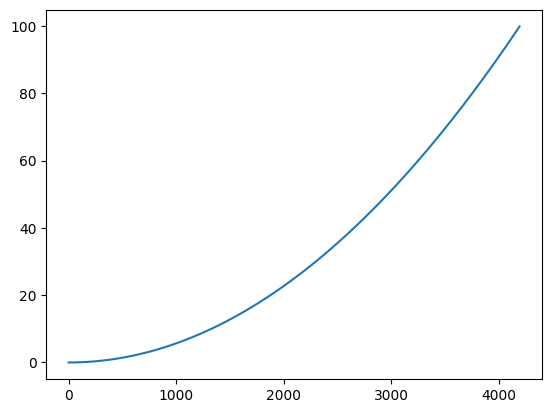

In [70]:
plt.plot(x0, z0)
plt.show()

In [71]:
q0=np.zeros(12*N)

In [72]:
for j in range(1,12):
    if j==1:
        q0[(j-1)*N:j*N]=x0
    elif j==5:
        q0[(j-1)*N:j*N]=z0

In [73]:
def static_func(Q): 
    t=0

    x,y,z=Q[0:N],Q[2*N:3*N],Q[4*N:5*N]
    dx,dy,dz=Q[1*N:2*N],Q[3*N:4*N],Q[5*N:6*N]
    φ,θ,ψ=Q[6*N:7*N],Q[8*N:9*N],Q[10*N:11*N]
    dφ,dθ,dψ=Q[7*N:8*N],Q[9*N:10*N],Q[11*N:12*N]
    
    RET = Ret(φ,θ,ψ)

    η = [x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]

    tau_force = np.array([-Fx_0,Fy_0,0,0,0,0])

    Z0 = tau_force[:3]    
    Z1 = d_s(ne, x, y, z, φ, θ, ψ).T
    Z2 = ne_hat(x, y, z, dx, dy, dz).T


    Z = (Z1 + Z2 - Z0)


############################################################
    ddx,ddy, ddz = (Z/Ws[0]).T
############################################################
    
    C0 = np.einsum('ijk,kp->ijp', Π(φ,θ,ψ), tau_force[3:].reshape(3,1))
    C1 = d_s(me, φ, θ, ψ, φ, θ, ψ)
    C = (C1.T - C0.squeeze())
 
    A0 = Jrho(RET,Jrho0)
    A_fin = np.einsum('ijk,ikr->ijr',A0, Π(φ,θ,ψ))

    B = np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1))
    
    D = w_e(φ,θ,ψ,dφ,dθ,dψ)
    
    G = np.cross(d_s(phi,x,y,z,φ, θ, ψ).T, ne(x, y, z, φ, θ, ψ))
    L = np.einsum('ijk,ik->ij',RET, (DR@D.T).T) 
    
    H = np.cross(D,np.einsum('ijk,ik->ij', A0, D))

#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A_fin, C + G - L - H - np.einsum('ijk,ik->ij',A0, B)).T
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

    return ans

In [74]:
root_ = root(static_func, q0, method='df-sane')

In [75]:
root_

 message: too many function evaluations required
 success: False
     fun: [ 1.202e+02  1.202e+02 ...  0.000e+00  0.000e+00]
       x: [ 2.152e+03  2.213e+03 ...  0.000e+00  0.000e+00]
     nit: 446
    nfev: 1000
  method: df-sane

In [76]:
x0_, z0_=root_.x[:N],root_.x[4*N:5*N]

In [77]:
# q0 = root_.x                                            # start from static solution

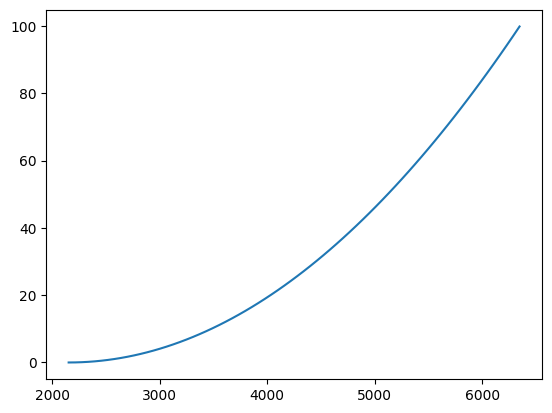

In [78]:
plt.plot(x0_, z0_)
plt.show()

### Finite Element Model of the Space Frame Element

In [79]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return np.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [80]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L

    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3],
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])


    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = np.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])


    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)

In [81]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]

    return K

In [82]:
def FEA(coord, elcon, bc_node, bc_val, vessel_movement, coefs,
          E=210e6, G=84e6, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):

    coord=np.array(coord)
    elcon=np.array(elcon)

    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))

    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])
        
        
    glob_force=np.dot(K, np.array(vessel_movement))
    
    glob_force[-6:]=np.multiply(glob_force[-6:], coefs)
    glob_force = np.zeros(len(vessel_movement))


    F=np.zeros(len(coord)*6)
    for i in range(len(vessel_movement)):
        if vessel_movement[i]:
            F[i]=glob_force[i]

    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m

    bc=np.array([bc_node,
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=scipy.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, check_finite=True)[0]
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    

#     Q=np.dot(K,d).T-F
    return d, np.dot(K,d).T

In [83]:
# 10 The Space Frame Element - verification
d,f=FEA(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [0, 2],
                      [0, 3]]),
        bc_node=list(range(6)),
        bc_val=[ -0.0705e-4, -0.0007e-4, 0.1418e-4, 0.0145e-4, 0.0175e-4,0.0114e-4],
        vessel_movement=[ 0, 0, 0, 0, 0,0.0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                       ],
        coefs=[1,1,1,1,1,1])

In [84]:
d

array([-7.050e-06, -7.000e-08,  1.418e-05,  1.450e-06,  1.750e-06,
        1.140e-06, -7.050e-06,  3.350e-06,  8.930e-06,  1.450e-06,
        1.750e-06,  1.140e-06, -1.230e-05,  4.280e-06,  1.418e-05,
        1.450e-06,  1.750e-06,  1.140e-06, -2.490e-06, -7.000e-08,
        8.380e-06,  1.450e-06,  1.750e-06,  1.140e-06])

In [85]:
f

array([ 2.18575158e-15, -1.86923231e-17, -3.84067778e-15,  9.71445147e-17,
        4.94078553e-17, -1.38777878e-17, -5.59719372e-16, -2.94360890e-17,
        2.29749217e-17,  3.06625927e-19,  2.51331616e-17,  5.88721780e-17,
        1.93123512e-17,  1.42708111e-17,  1.72398987e-15, -2.85416222e-17,
        6.63802780e-17, -6.09863722e-20,  2.08166817e-17,  4.64478987e-17,
        2.42861287e-17,  1.38777878e-17,  3.17637355e-20, -1.38777878e-17])

In [86]:
def PipeForce(X,Y,Z,vessel_movement,coefs, E=210e6, G=84e6,  
              A=Ar, Iy=39.4925/7860, Iz=39.4925/7860, J=1.0062*1e-2,
#               A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5
             ):
    coord=np.stack((X,Y,Z)).T
    elcon=[]
    for i in range(1,len(X)):
        elcon.append([i-1,i])

    bc_node = list(range(6))+list(range((len(X)-6),len(X)))
    bc_val = [0]*6 + vessel_movement

    vessel_move=np.zeros(len(X)*6)
#     vessel_move[-6:]=vessel_movement

    d,f=FEA(coord,elcon,bc_node,bc_val,vessel_move, coefs, E,G,A,Iy,Iz,J)

    fors=[]
    for i in range(0,len(f),6):
        fors.append(f[i:i+3])

    mom =[]
    for i in range(3,len(f),6):
        mom.append(f[i:i+3])

    angle=[]
    for i in range(3,len(d),6):
        angle.append(d[i:i+3])
    fors[0][0]=0
    fors[0][1]=0
    fors[0][2]=0
    return np.array(fors), np.array(mom), np.array(angle)

In [87]:
fors, mom, angle = PipeForce(x0_,list([0 for i in range(len(z0))]),z0_,
[0.01,
 0.02,
 0.03,
 0.01,
 -0.05,
 0.03],
 [1,1,1,1,1,1]
)

In [88]:
fors

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.54747351e-12,  1.12502541e-09, -7.33884065e-10],
       [ 1.77237780e-10,  5.36537037e-10, -2.30244268e-10],
       [-2.62673439e-10,  1.18664072e-11, -8.01016142e-10],
       [ 2.21689334e-11,  1.49748303e-09, -1.43081991e-10],
       [ 2.45336196e-10,  1.92468974e-09, -9.83902737e-10],
       [-1.68256520e-10, -4.66343408e-10, -4.69867700e-10],
       [-1.14596332e-10,  6.99866998e-10,  4.08959977e-10],
       [ 4.63842298e-11, -1.67376868e-09, -7.77529152e-10],
       [ 1.63709046e-10, -4.59550620e-10,  8.76385187e-10],
       [-8.36735126e-11, -9.32715238e-10, -4.64559946e-10],
       [ 4.42838768e+02, -4.06053318e-01,  1.73683363e+00],
       [ 5.45696821e-12,  7.52180540e-10, -1.24873623e-09],
       [-7.74889486e-10,  4.54917881e-10,  4.31214175e-10],
       [ 7.60337571e-10, -7.10670633e-10,  1.40585144e-09],
       [ 2.29192665e-10, -4.74898454e-10, -1.10750875e-09],
       [-2.80124368e-10,  3.72267550e-10

In [89]:
mom

array([[-3.82210131e+01,  1.99334181e+02,  8.87288644e+01],
       [ 6.12004669e-10,  1.90311766e-10, -1.68417752e-09],
       [ 2.76770606e-10, -8.37815151e-10, -9.71795089e-10],
       [ 1.06292930e-09,  4.52018867e-10, -5.67297320e-10],
       [ 7.01252389e-11, -2.92459390e-10, -7.11679604e-10],
       [-3.66156883e-10,  2.00088834e-11, -3.43399575e-09],
       [-2.42721399e-10,  6.02256023e-11, -1.15005605e-09],
       [-1.86847160e-09, -5.87533577e-10,  1.09491793e-09],
       [-8.18296542e-10,  6.34088337e-11, -1.13595888e-09],
       [-4.51791493e-10,  1.81671567e-10, -2.92420310e-10],
       [ 1.10856035e-09, -1.61987647e+02,  1.82777395e+02],
       [ 3.71903976e+01,  2.95472091e-10,  3.35603545e-10],
       [-1.21919896e-09, -9.34505806e-11, -2.60070010e-09],
       [-1.12754606e-09, -4.48835635e-10,  6.50794973e-10],
       [-1.13232090e-10, -1.62572178e-11, -6.01175998e-10],
       [ 1.38328460e-09,  3.62888386e-10, -8.04448064e-10],
       [ 1.39078793e-09,  9.89643922e-11

In [90]:
angle

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.00274811, -0.00871001, -0.00440045],
       [ 0.00549461, -0.01240818, -0.0073786 ],
       [ 0.00823877, -0.01216477, -0.00893443],
       [ 0.01097983, -0.00905006, -0.00906795],
       [ 0.01371707, -0.0041343 , -0.00777915],
       [ 0.01644975,  0.00151222, -0.00506802],
       [ 0.01917713,  0.00681921, -0.00093455],
       [ 0.02189848,  0.01071639,  0.00462126],
       [ 0.02461306,  0.01213343,  0.01159944],
       [ 0.02732013,  0.01      ,  0.02      ],
       [ 0.03      ,  0.01257799,  0.01929287],
       [ 0.03      ,  0.01257799,  0.01929287],
       [ 0.03      ,  0.01257799,  0.01929287],
       [ 0.03      ,  0.01257799,  0.01929287],
       [ 0.03      ,  0.01257799,  0.01929287],
       [ 0.03      ,  0.01257799,  0.01929287],
       [ 0.03      ,  0.01257799,  0.01929287],
       [ 0.03      ,  0.01257799,  0.01929287],
       [ 0.03      ,  0.01257799,  0.01929287],
       [ 0.03      ,  0.01257799,  0.019

### Vessle Simulation

In [91]:
sampleTime = 0.001              # sample time [seconds]
Number = 100000                      # number of samples

In [92]:
Number*sampleTime

100.0

In [93]:
vehicle=semisub('DPcontrol',0.1,-0.1,40.0,0,0)

In [94]:
[simTime, simData] = simulate(Number, sampleTime, vehicle)

In [95]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

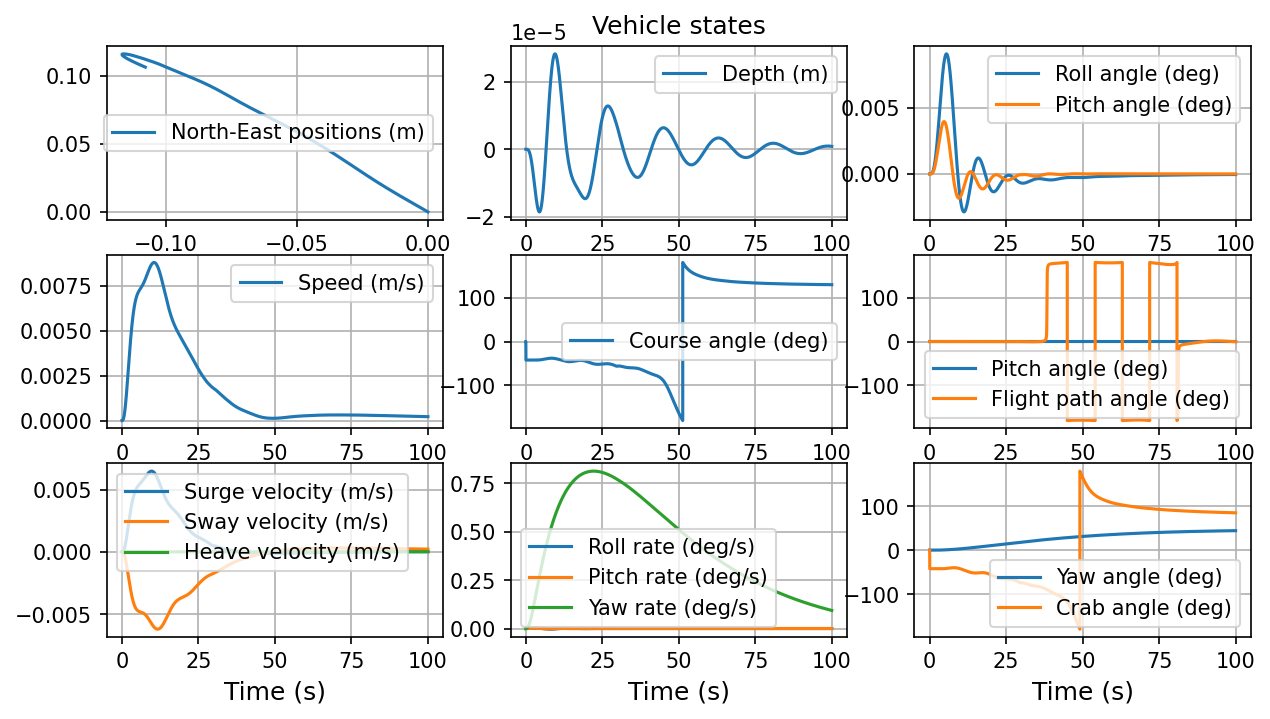

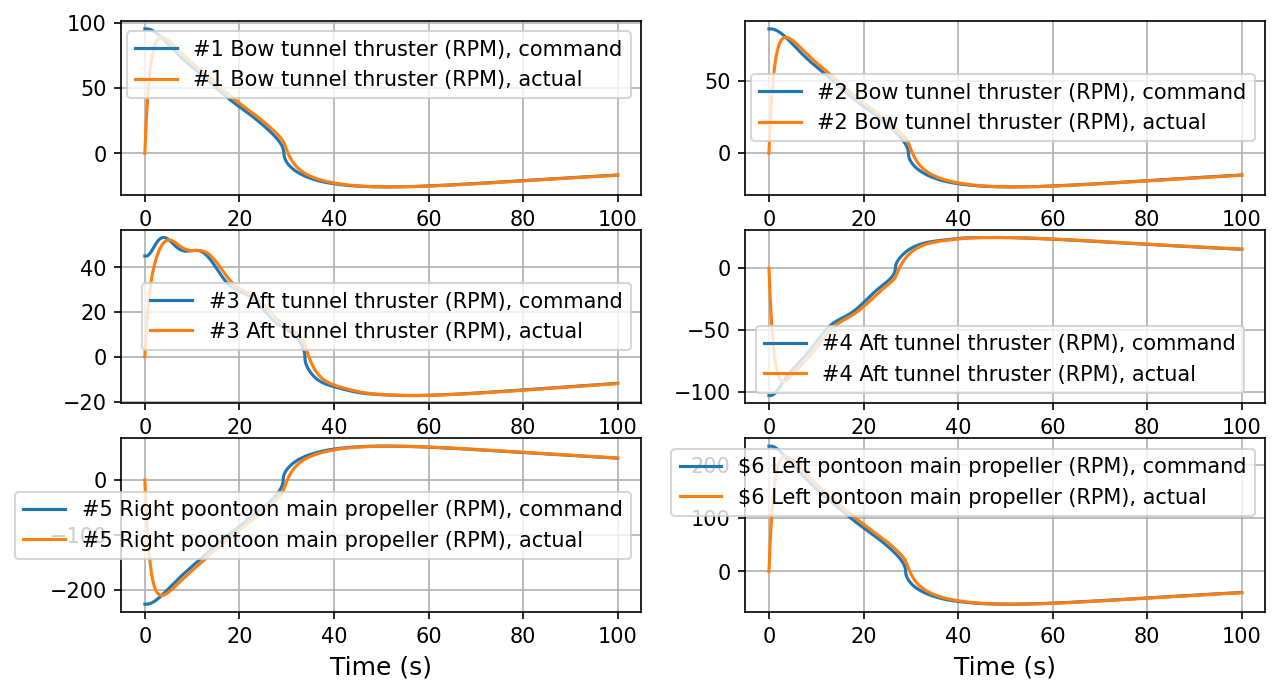

In [96]:
plotVehicleStates(simTime, simData, 1)
plotControls(simTime, simData, vehicle, 2)

In [97]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'

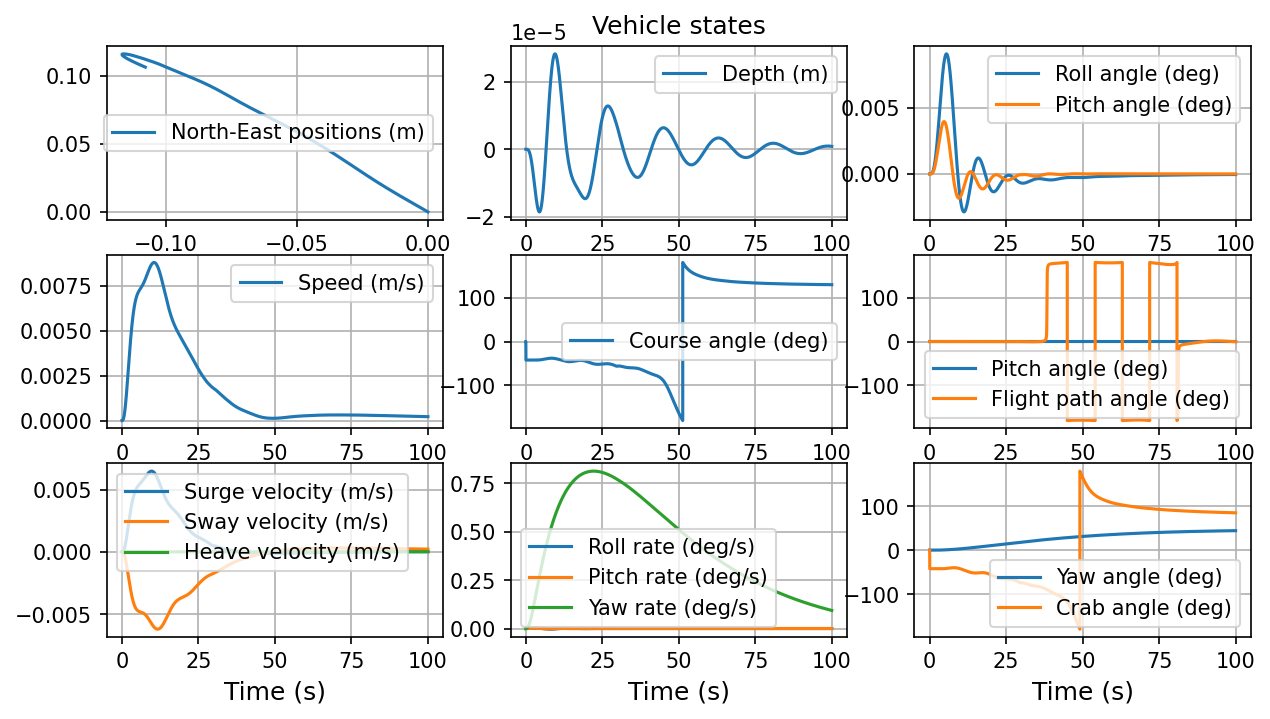

In [98]:
plotVehicleStates(simTime, simData, 3)

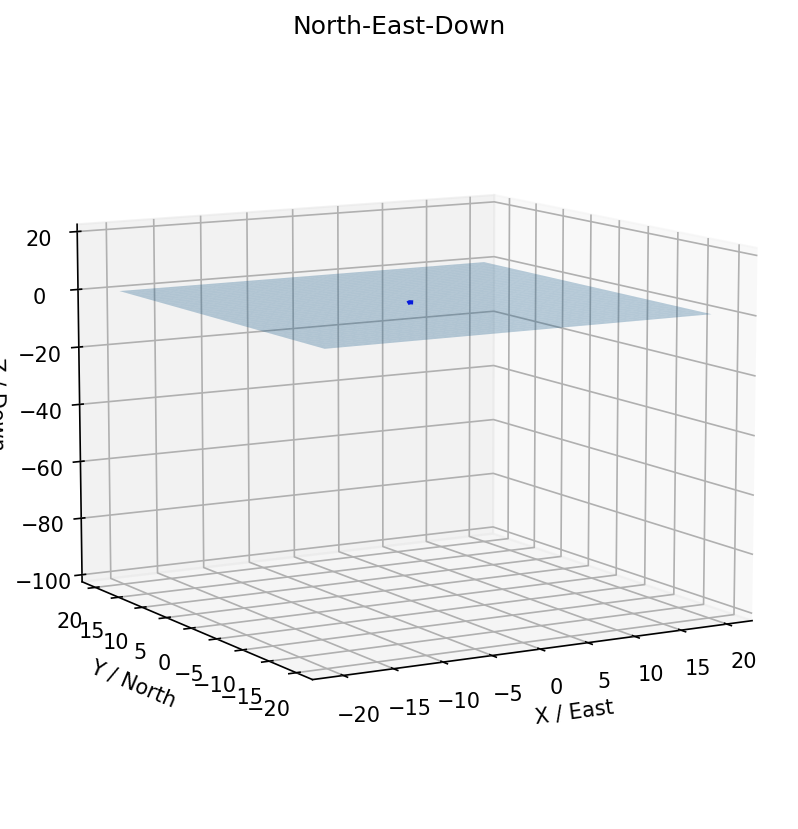

In [99]:
plot3D(simData, numDataPoints, FPS, filename, 3)

In [100]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [101]:
class MyTime:
    def __init__(self):
        self.my_t = 0
        self.v_m = np.array([0,0,0,0,0,0]).astype(np.float64)
        self.progression = [i for i in range(650)]
        self.wall_clock = datetime.now()
        self.x_ve = 0
        self.y_ve = 0
        self.z_ve = 0
        self.phi_ve = 0
        self.theta_ve = 0
        self.psi_ve = 0

In [102]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())
    return np.array(ans)  

In [103]:
V_rho=np.zeros(Jrho0.shape)
np.fill_diagonal(V_rho, vessel_inertia)

In [104]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Jrho1=inert(V_rho, Jrho0, x0)

### Dynamics

In [105]:
def dynamic_func(t, Q, coefs, T):
    
    x,y,z=Q[0:N],Q[2*N:3*N],Q[4*N:5*N]
    dx,dy,dz=Q[1*N:2*N],Q[3*N:4*N],Q[5*N:6*N]
    φ,θ,ψ=Q[6*N:7*N],Q[8*N:9*N],Q[10*N:11*N]
    dφ,dθ,dψ=Q[7*N:8*N],Q[9*N:10*N],Q[11*N:12*N]
    
    idx = find_nearest(np.array(ans_t),  t)
    
    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_ve = ssa(simData[:, 5][idx])
    
    RET = Ret(φ,θ,ψ)

    vessel_movement = np.zeros(6)
    
    vessel_movement[0] = x_ve - T.x_ve
    vessel_movement[1] = y_ve - T.y_ve
    vessel_movement[2] = z_ve - T.z_ve 
    vessel_movement[3] = phi_ve - T.phi_ve
    vessel_movement[4] = theta_ve - T.theta_ve
    vessel_movement[5] = psi_ve - T.psi_ve
    
    

    fors, mom, angle = PipeForce(x, y, z, list(vessel_movement), coefs)
    
    
#     Z0 = fors.squeeze()
    Z0 = np.einsum('ijk,ik->ij', RET, fors) 
    Z1 = d_s(ne, x, y, z, φ, θ, ψ).T
    Z2 = ne_hat(x, y, z, dx, dy, dz).T

    Z = (Z1 + Z2 
         - Z0
        )


############################################################
#     ddx,ddy, ddz = (Z/(M_t.reshape(-1, 1))).T
    ddx,ddy, ddz = (Z/Ws[0]).T
############################################################
    
#     C0 = np.einsum('ijk,ik->ij', Π(φ,θ,ψ), angle).squeeze()
    C0 = np.einsum('ijk,ik->ij', np.einsum('ijk,ikr->ijr', Π(φ,θ,ψ), RET), angle)
    
    C1 = d_s(me, φ, θ, ψ, φ, θ, ψ)
    C = (C1.T 
         - C0
        )


    A0 = Jrho(RET,Jrho0)
#     A0 = Jrho(RET,Jrho1) 
    A_fin = np.einsum('ijk,ikr->ijr', A0, Π(φ,θ,ψ))
    

    B = np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1))
    
    D = w_e(φ,θ,ψ,dφ,dθ,dψ)
    
    G = np.cross(d_s(phi,x,y,z,φ, θ, ψ).T, ne(x, y, z, φ, θ, ψ))
    
    L = np.einsum('ijk,ik->ij',RET, (DR@D.T).T) 

    H = np.cross(D, np.einsum('ijk,ik->ij', A0, D))
    

#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A_fin, (C + G - L - H - np.einsum('ijk,ik->ij', A0, B))).T
#############################################


    T.x_ve=x_ve
    T.y_ve=y_ve
    T.z_ve=z_ve
    T.phi_ve = phi_ve
    T.theta_ve = theta_ve
    T.psi_ve = psi_ve

    if t>T.progression[0]:
        T.progression.pop(0)
        print('Physical time: ', t, ' Iteration wall clock time: ', datetime.now() - T.wall_clock )
        T.wall_clock = datetime.now()
        
    ans=np.concatenate([dx, ddx, 
                        dy, ddy, 
                        dz, ddz, 
                        dφ, ddφ, 
                        dθ, ddθ, 
                        dψ, ddψ
                       ], axis=0)
    
    return ans

In [106]:
# integration parameters
tspan = (0., 50)
T_ = MyTime()
coefs = [1, 1, 1, 1, 1, 1]

# initial conditions
q0[6*N+(N-1)], q0[8*N+(N-1)], q0[10*N+(N-1)] = (
    ssa(simData[:, 3][10]), ssa(simData[:, 4][10]), ssa(simData[:, 5][10]))

In [107]:
startTime1 = datetime.now()
us_=solve_ivp(dynamic_func,
             tspan,
             q0,
             args=(coefs,T_,))
print(datetime.now() - startTime1)

Physical time:  0.00010311665657244964  Iteration wall clock time:  0:00:00.822064
Physical time:  1.0196983928241754  Iteration wall clock time:  0:00:08.456113
Physical time:  2.0467421688066287  Iteration wall clock time:  0:00:18.088939
Physical time:  3.042669376459342  Iteration wall clock time:  0:00:09.743541
Physical time:  4.008137279464148  Iteration wall clock time:  0:00:09.878155
Physical time:  5.004524319279557  Iteration wall clock time:  0:00:10.054709
Physical time:  6.035793002753087  Iteration wall clock time:  0:00:08.886112
Physical time:  7.043774229959015  Iteration wall clock time:  0:00:09.225226
Physical time:  8.053513874932042  Iteration wall clock time:  0:00:08.308704
Physical time:  9.093979528907976  Iteration wall clock time:  0:00:09.677706
Physical time:  10.05626905126065  Iteration wall clock time:  0:00:09.914831
Physical time:  11.030701783510029  Iteration wall clock time:  0:00:12.144946
Physical time:  12.006581962485543  Iteration wall clock

### Results

In [108]:
fin=us_

In [109]:
fin

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.031e-02 ...  5.000e+01  5.000e+01]
        y: [[ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            [ 6.079e+01  6.079e+01 ...  5.988e+01  5.988e+01]
            ...
            [ 0.000e+00  2.481e-17 ...  1.274e-08  1.269e-08]
            [ 0.000e+00  2.481e-17 ...  1.274e-08  1.269e-08]]
      sol: None
 t_events: None
 y_events: None
     nfev: 2654
     njev: 0
      nlu: 0

In [110]:
t=fin.t

In [111]:
fin=fin.y.T

In [112]:
t.shape, fin.shape

((441,), (441, 840))

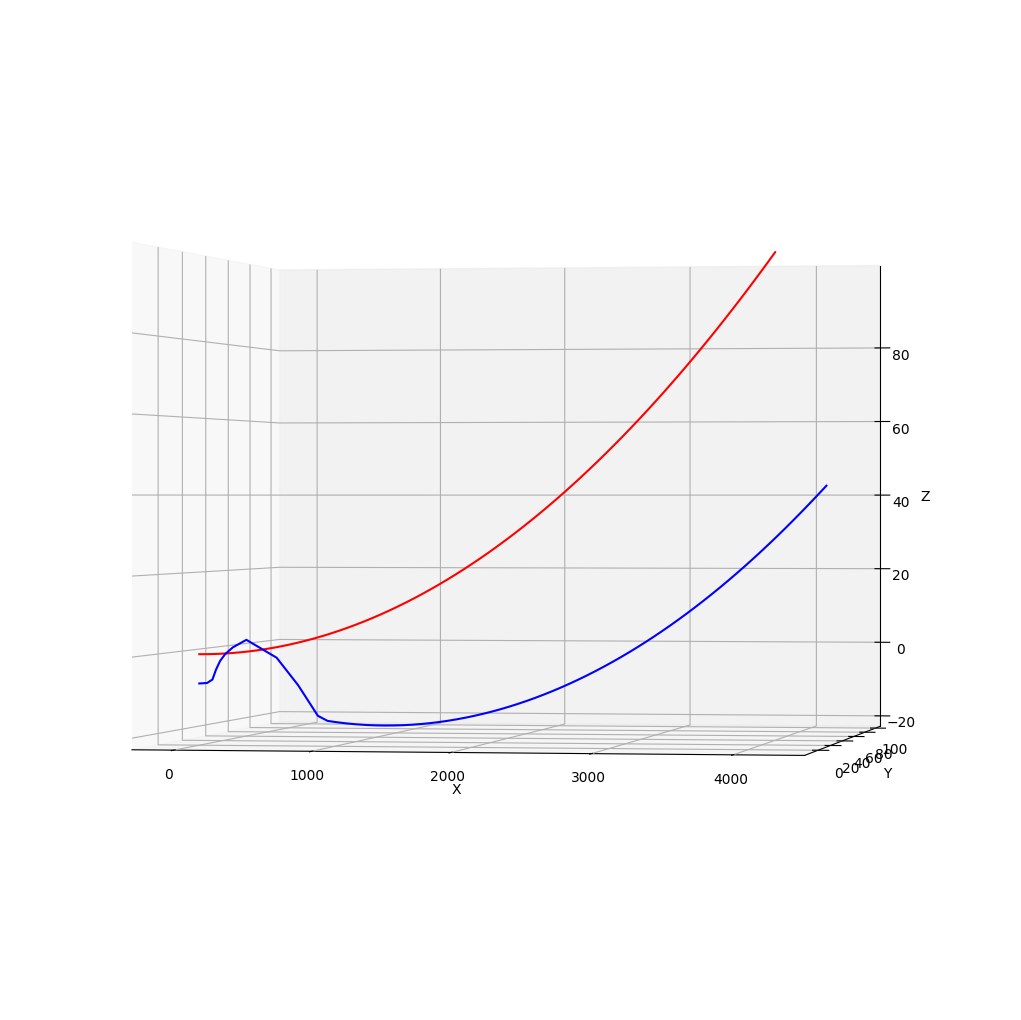

In [113]:
fig=plt.figure(figsize=(13,13))
ax = fig.add_subplot(projection = '3d')

X0=fin[0,[i for i in range(0,N)]]
Y0=fin[0,[i for i in range(2*N,3*N)]]
Z0=fin[0,[i for i in range(4*N,5*N)]]

j=-1
X=fin[j,[i for i in range(0,N)]]
Y=fin[j,[i for i in range(2*N,3*N)]]
Z=fin[j,[i for i in range(4*N,5*N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b')
# ax.plot(x_fine, y_fine, z_fine, color='b')
# ax.view_init(-45,-45)
# ax.view_init(-30,-30)
ax.view_init(0,-80)
plt.show()

In [114]:
X,Y,Z

(array([   0.        ,   59.87645914,  118.72383101,  177.20127516,
         235.94006796,  295.73320764,  357.39617313,  421.47696753,
         483.12936214,  533.0341873 ,  576.53573593,  638.70006793,
         698.00677646,  757.42450487,  816.89327439,  876.40767704,
         935.96319481,  995.55600765, 1055.18285076, 1114.84090839,
        1174.52773122, 1234.24117333, 1293.97934214, 1353.74055807,
        1413.52332278, 1473.32629248, 1533.14825727, 1592.98812247,
        1652.84489396, 1712.71766622, 1772.6056109 , 1832.50796865,
        1892.42404038, 1952.35318235, 2012.29479808, 2072.24833631,
        2132.21328315, 2192.18916204, 2252.17552694, 2312.17196241,
        2372.17807862, 2432.19351026, 2492.21791444, 2552.2509674 ,
        2612.29236638, 2672.34182347, 2732.39906894, 2792.46384622,
        2852.53591391, 2912.61503829, 2972.70100432, 3032.79360404,
        3092.89263899, 3152.99792554, 3213.10927663, 3273.22652892,
        3333.34951639, 3393.47808351, 3453.61208

In [115]:
X0,Y0,Z0

(array([   0.        ,   60.78607636,  121.57215271,  182.35822907,
         243.14430542,  303.93038178,  364.71645814,  425.50253449,
         486.28861085,  547.0746872 ,  607.86076356,  668.64683992,
         729.43291627,  790.21899263,  851.00506898,  911.79114534,
         972.5772217 , 1033.36329805, 1094.14937441, 1154.93545076,
        1215.72152712, 1276.50760348, 1337.29367983, 1398.07975619,
        1458.86583254, 1519.6519089 , 1580.43798526, 1641.22406161,
        1702.01013797, 1762.79621432, 1823.58229068, 1884.36836704,
        1945.15444339, 2005.94051975, 2066.7265961 , 2127.51267246,
        2188.29874882, 2249.08482517, 2309.87090153, 2370.65697788,
        2431.44305424, 2492.2291306 , 2553.01520695, 2613.80128331,
        2674.58735966, 2735.37343602, 2796.15951238, 2856.94558873,
        2917.73166509, 2978.51774144, 3039.3038178 , 3100.08989416,
        3160.87597051, 3221.66204687, 3282.44812322, 3343.23419958,
        3404.02027594, 3464.80635229, 3525.59242

In [116]:
us=fin.T

In [117]:
us.shape

(840, 441)

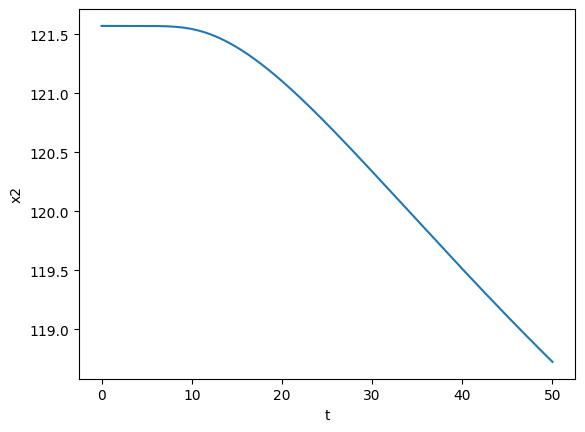

In [118]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

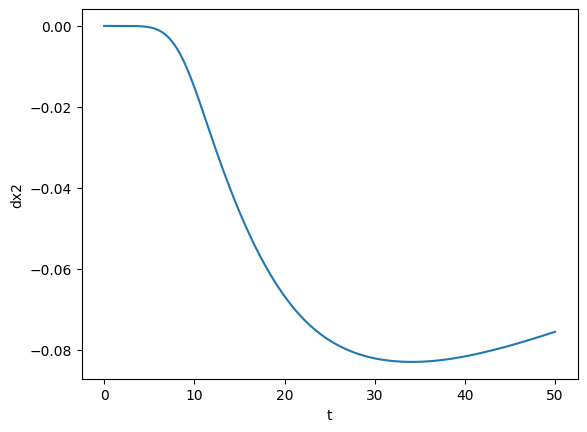

In [119]:
plt.plot(t,us.T[:,N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

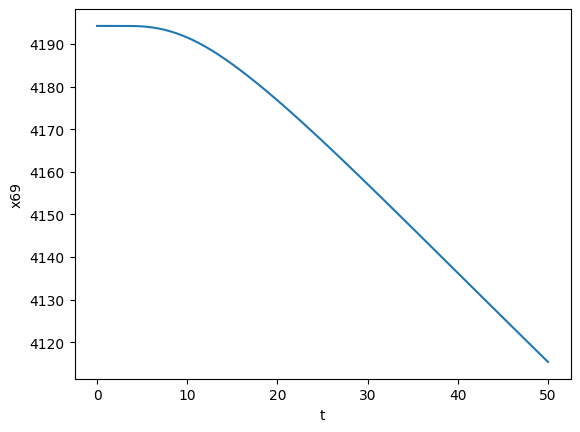

In [120]:
plt.plot(t,us.T[:,N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x{}'.format(N-1))
plt.show()

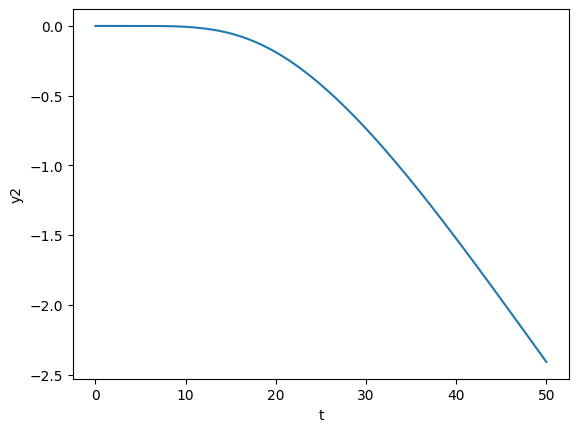

In [121]:
plt.plot(t,us.T[:,2*N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

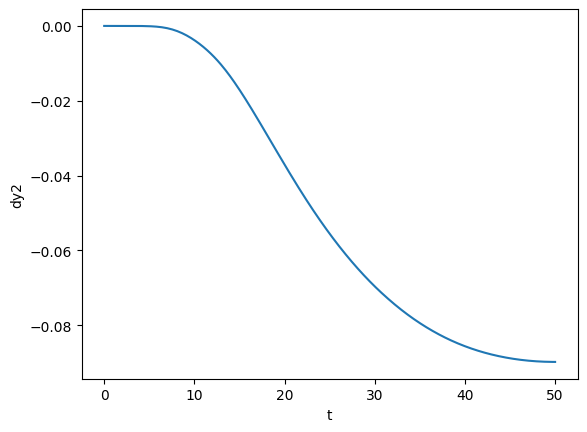

In [122]:
plt.plot(t,us.T[:,3*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

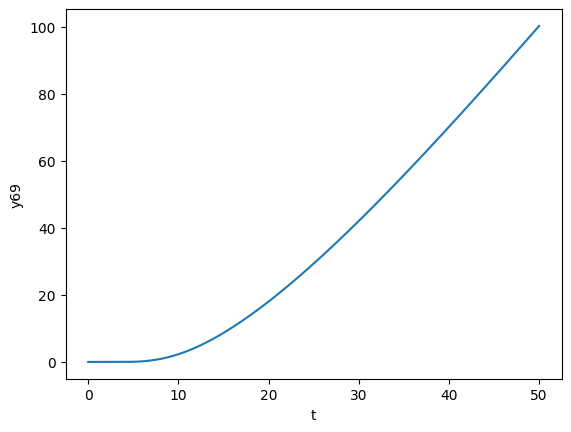

In [123]:
plt.plot(t,us.T[:,2*N+(N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('y{}'.format(N-1))
plt.show()

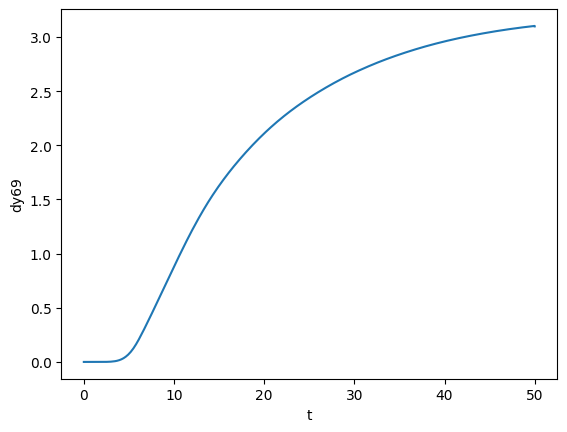

In [124]:
plt.plot(t,us.T[:,3*N+(N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('dy{}'.format(N-1))
plt.show()

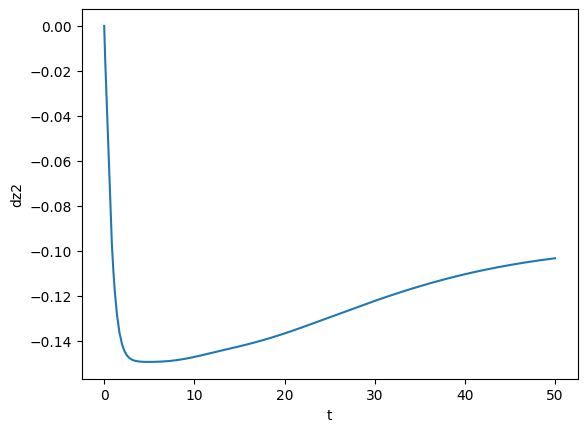

In [125]:
plt.plot(t,us.T[:,5*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

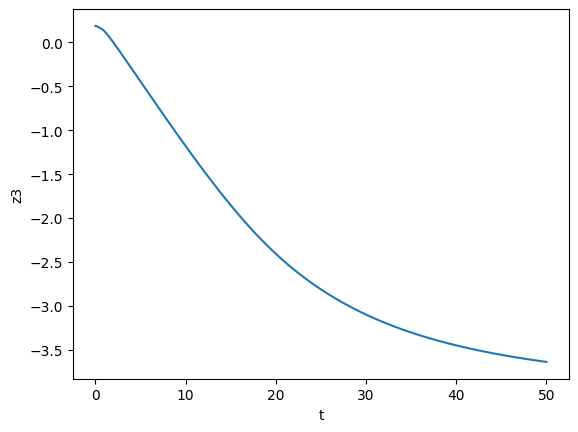

In [126]:
plt.plot(t,us.T[:,4*N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

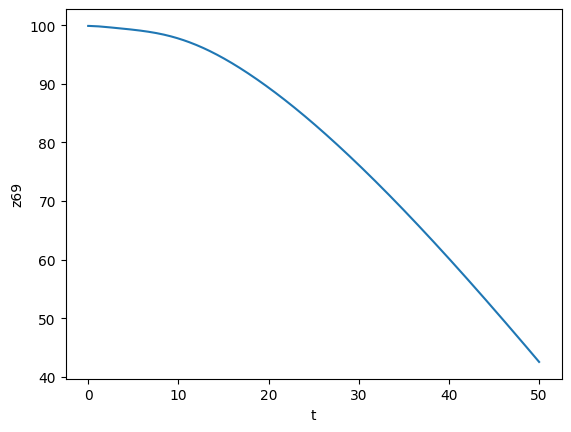

In [127]:
plt.plot(t,us.T[:,4*N + (N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('z{}'.format(N-1))
plt.show()

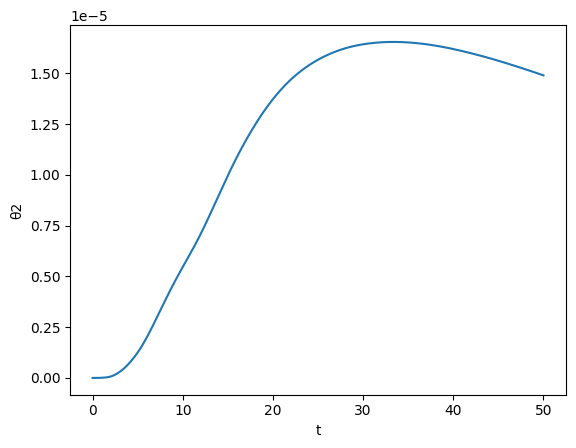

In [128]:
plt.plot(t,us.T[:,8*N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

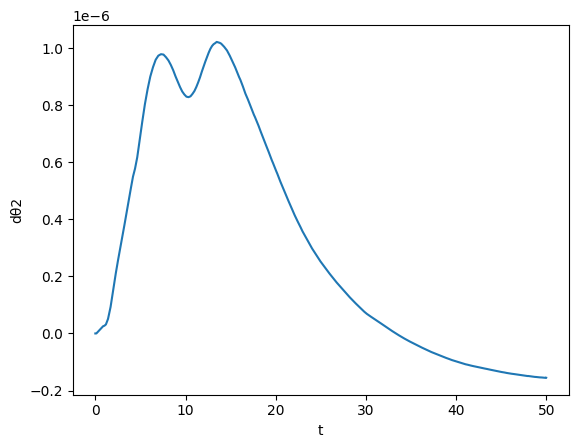

In [129]:
plt.plot(t,us.T[:,9*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

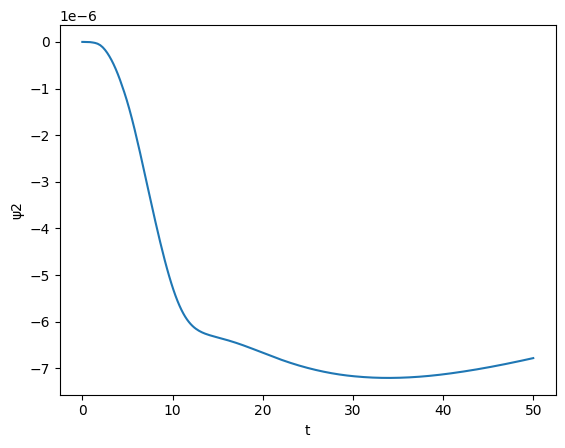

In [130]:
plt.plot(t,us.T[:,10*N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

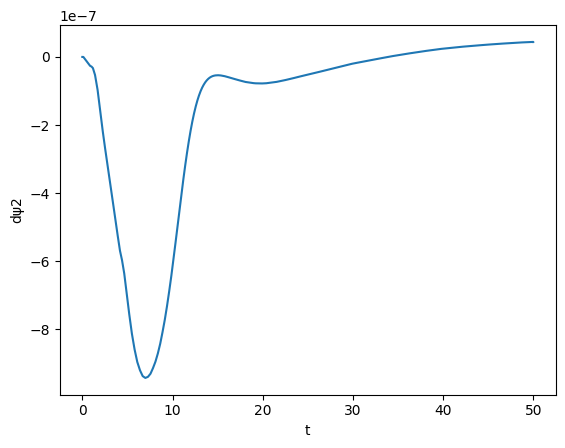

In [131]:
plt.plot(t,us.T[:,11*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()

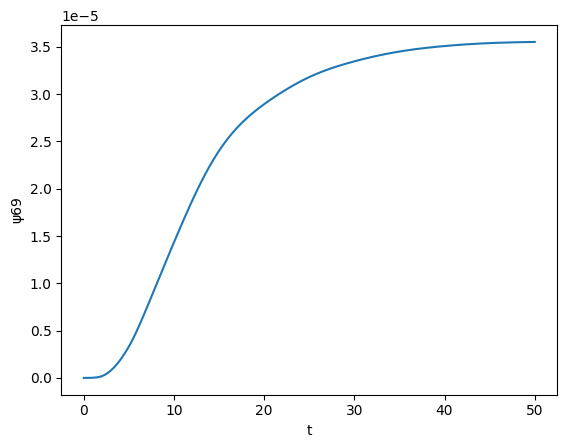

In [132]:
plt.plot(t,us.T[:,10*N + (N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('ψ{}'.format(N-1))
plt.show()